In [ ]:
# Research plan:
# 1. Run random forst to identify relevant categorical variables
# 2. ??

Section I: Loading and Transforming Data

In [1]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree, neighbors, metrics, grid_search, cross_validation, feature_selection, linear_model

pd.set_option('display.max_rows', 30)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 100)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# load the data
df = pd.read_csv('Consumer_Complaints.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(586385, 18)

In [4]:
# print column names
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [5]:
# subset dataframe with rows with timely response
timely_df = df[df['Timely response?'] == 'Yes']
timely_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,07/30/2013,Closed with explanation,Yes,No,468882
1,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
2,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879
3,07/29/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,NaN,NaN,Ocwen,CA,92626,NaN,NaN,Web,07/31/2013,Closed with explanation,Yes,No,475101
4,07/29/2013,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,06106,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,475823


In [6]:
# count number of rows with timely response from defendant
timely_count = len(timely_df)
timely_count

571523

In [7]:
# subset dataframe with rows with untimely response
untimely_df = df[df['Timely response?'] == 'No']
untimely_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
17,07/29/2013,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"Asset Management Professionals, LLC",PA,19145,Older American,NaN,Phone,08/01/2013,Closed with explanation,No,NaN,468904
175,07/30/2013,Mortgage,VA mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Prudent Law Group,FL,32218,Servicemember,NaN,Phone,08/09/2013,Untimely response,No,NaN,470126
190,07/31/2013,Mortgage,Other mortgage,Settlement process and costs,NaN,NaN,NaN,Embrace Home Loans Inc,NC,27407,NaN,NaN,Referral,08/02/2013,Closed with explanation,No,NaN,471177
193,07/31/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,FL,33150,NaN,NaN,Referral,08/02/2013,Closed with explanation,No,NaN,471183
199,07/30/2013,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,Credit Bureau of Napa,AZ,85015,Older American,NaN,Phone,08/09/2013,Closed,No,No,470259


In [8]:
# count number of rows with untimely response from defendant
untimely_count = len(untimely_df)
untimely_count

14862

In [9]:
# percentage of rows with untimely response
untimely_rate = untimely_count/len(df)
untimely_rate

0.025345123084662805

In [10]:
# take random sample of 14628 rows from timely df (to equalize row count by timeliness/untimeliness)
timely_df_sample = timely_df.sample(14628)
timely_df_sample.shape

(14628, 18)

In [11]:
# join timely response to sampled untimely response df
train_data = [timely_df_sample, untimely_df]
train_df = pd.concat(train_data)
train_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [12]:
train_df.shape

(29490, 18)

In [13]:
# create dummies for binary variables
timely_dummies = pd.get_dummies(train_df['Timely response?'], prefix = 'Timely')
disputed_dummies = pd.get_dummies(train_df['Consumer disputed?'], prefix = 'Disputed')
consent_dummies = pd.get_dummies(train_df['Consumer consent provided?'], prefix = 'Consent')

In [14]:
# create dummies for remaining categorical variables
product_dummies = pd.get_dummies(train_df['Product'], prefix = 'Product')
sub_product_dummies = pd.get_dummies(train_df['Sub-product'], prefix = 'Sub_Product')
issue_dummies = pd.get_dummies(train_df['Issue'], prefix = 'Issue')
sub_issue_dummies = pd.get_dummies(train_df['Sub-issue'], prefix = 'Sub_Issue')
company_public_response_dummies = pd.get_dummies(train_df['Company public response'], prefix = 'Public_Response')
company_dummies = pd.get_dummies(train_df['Company'], prefix = 'Company')
state_dummies = pd.get_dummies(train_df['State'], prefix = 'State')
zip_dummies = pd.get_dummies(train_df['ZIP code'], prefix = 'ZIP')
tags_dummies = pd.get_dummies(train_df['Tags'], prefix = 'Tags')
submitted_via_dummies = pd.get_dummies(train_df['Submitted via'], prefix = 'Submission_Method')
company_response_dummies = pd.get_dummies(train_df['Company response to consumer'], prefix = 'Response_To_Consumer')

In [15]:
# Add dummies to test dataframe
train_df = train_df.join([timely_dummies, disputed_dummies, consent_dummies, product_dummies, sub_product_dummies,
                        issue_dummies, sub_issue_dummies, company_public_response_dummies, company_dummies, state_dummies,
                        zip_dummies, tags_dummies, submitted_via_dummies, company_response_dummies])

In [16]:
# split data into training and test groups
overall_df = train_df
train_df = overall_df.sample(frac = .6, random_state = 1)
test_df = overall_df.drop(train_df.index)

In [19]:
# Define zip code dummies for training and test data
zip_dummies_train = train_df[ [name for name in train_df.columns if 'ZIP_' in name] ]
zip_dummies_test = test_df[ [name for name in test_df.columns if 'ZIP_' in name] ]

In [20]:
# Define product dummies for training and test data
product_dummies_train = train_df[ [name for name in train_df.columns if 'Product_' in name] ]
product_dummies_test = test_df[ [name for name in test_df.columns if 'Product_' in name] ]

In [21]:
# check size of training dataframe
train_df.shape

(17694, 13459)

In [22]:
# check size of test dataframe
test_df.shape

(11796, 13459)

Section II: Descriptive Analysis

In [71]:
# check for association between product and timeliness
pd.crosstab(index = train_df['Product'], columns = train_df['Timely_Yes'], colnames = ['Timely Response?'])

Timely Response?,0.0,1.0
Product,,
Bank account or service,435,1021
Consumer Loan,349,350
Credit card,365,998
Credit reporting,89,1533
Debt collection,4517,1570
Money transfers,42,61
Mortgage,2514,2944
Other financial service,29,7
Payday loan,250,61


In [25]:
# check for association between consumer disputation and timeliness
pd.crosstab(index = train_df['Consumer disputed?'], columns = train_df['Timely_Yes'], colnames = ['Timely_Response?'])

Timely_Response?,0.0,1.0
Consumer disputed?,,
No,4161,6563
Yes,1090,1820


In [26]:
# check for association between company and timeliness
Timely_Crosstab = pd.crosstab(index = train_df['Company'], columns = train_df['Timely_Yes'], colnames = ['Timely'])
# find the five companies with the highest counts of untimely response
Timely_Crosstab.sort_values(0.0, ascending = False).head(5)

In [27]:
# find the five companies with the highest counts of untimely response
Timely_Crosstab.sort_values(0.0, ascending = False).head(5)

Timely,0.0,1.0
Company,,
Bank of America,924,837
Ocwen,324,358
Wells Fargo & Company,254,675
Citibank,201,396
"Mobiloans, LLC",110,0


In [28]:
train_df.sort('Timely_Yes', ascending = False).head(10)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Timely_No,Timely_Yes,Disputed_No,Disputed_Yes,Consent_Consent not provided,Consent_Consent provided,Consent_Consent withdrawn,Consent_Other,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Other financial service,Product_Payday loan,Product_Prepaid card,Product_Student loan,Sub_Product_(CD) Certificate of deposit,Sub_Product_Auto,Sub_Product_Cashing a check without an account,Sub_Product_Check cashing,Sub_Product_Checking account,Sub_Product_Conventional adjustable mortgage (ARM),Sub_Product_Conventional fixed mortgage,Sub_Product_Credit card,Sub_Product_Credit repair,Sub_Product_Debt settlement,Sub_Product_Domestic (US) money transfer,Sub_Product_FHA mortgage,Sub_Product_Federal student loan,...,ZIP_99206,ZIP_99208,ZIP_99212,ZIP_99216,ZIP_99217,ZIP_99223,ZIP_99224,ZIP_992XX,ZIP_99301,ZIP_99324,ZIP_99326,ZIP_99336,ZIP_99337,ZIP_99338,ZIP_99352,ZIP_99354,ZIP_993XX,ZIP_99501,ZIP_99502,ZIP_99507,ZIP_99576,ZIP_99577,ZIP_99645,ZIP_99654,ZIP_99664,ZIP_99687,ZIP_99708,ZIP_99709,ZIP_99712,ZIP_99775,ZIP_99801,ZIP_99901,ZIP_99999,Tags_Older American,"Tags_Older American, Servicemember",Tags_Servicemember,Submission_Method_Email,Submission_Method_Fax,Submission_Method_Phone,Submission_Method_Postal mail,Submission_Method_Referral,Submission_Method_Web,Response_To_Consumer_Closed,Response_To_Consumer_Closed with explanation,Response_To_Consumer_Closed with monetary relief,Response_To_Consumer_Closed with non-monetary relief,Response_To_Consumer_Closed with relief,Response_To_Consumer_Closed without relief,Response_To_Consumer_In progress,Response_To_Consumer_Untimely response
365973,11/13/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,CA,91366,Older American,NaN,Phone,11/14/2013,Closed with explanation,Yes,No,596216,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
178248,10/12/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,"To Whom It May Concern, I have been trying to ...",NaN,Ocwen,CA,906XX,NaN,Consent provided,Web,10/12/2015,Closed with explanation,Yes,Yes,1603040,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
211467,07/10/2013,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN,NaN,New York Community Bank,NJ,08817,NaN,NaN,Referral,07/12/2013,Closed with explanation,Yes,No,454366,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
107147,09/02/2014,Credit card,NaN,Closing/Cancelling account,NaN,NaN,NaN,Citibank,NY,10003,NaN,NaN,Web,09/02/2014,Closed with explanation,Yes,No,1011085,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [29]:
train_df.Timely_Yes.value_counts()

1.0    8843
0.0    8711
Name: Timely_Yes, dtype: int64

In [30]:
# check for association between U.S. state and timeliness
pd.crosstab(index = train_df['State'], columns = train_df['Timely_Yes'], colnames = ['Timely Response?'])

Timely Response?,0.0,1.0
State,,
AE,4,2
AK,5,5
AL,105,88
AP,4,4
AR,31,43
AS,1,0
AZ,184,185
CA,1373,1326
CO,158,152


In [31]:
# check for association between protected social group status and timeliness
pd.crosstab(index = [train_df['Tags']], columns = train_df['Timely_Yes'], colnames = ['Timely Response?'])

Timely Response?,0.0,1.0
Tags,,
Older American,555,769
"Older American, Servicemember",98,117
Servicemember,580,426


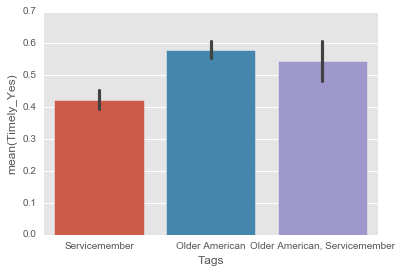

In [32]:
1

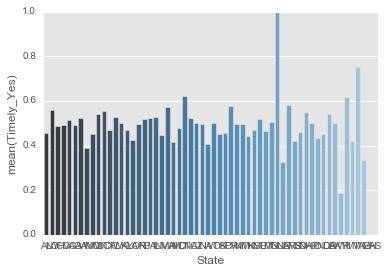

In [33]:
# plot U.S. State vs. mean timeliness
sns.barplot(x="State", y="Timely_Yes", data=train_df, palette = 'Blues_d', ci = None);

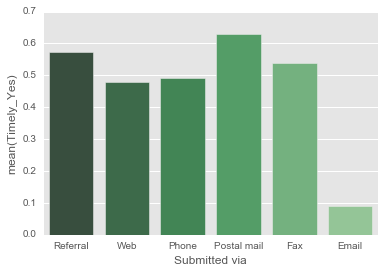

In [34]:
# plot submission method vs. mean timeliness
sns.barplot(x="Submitted via", y="Timely_Yes", data=train_df, palette = 'Greens_d', ci = None);

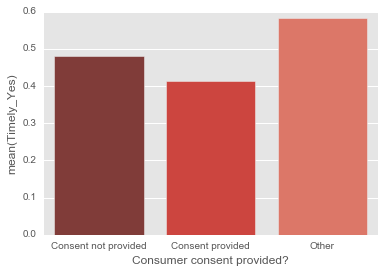

In [35]:
# plot complainant consent to sharing complaint vs. mean timeliness
sns.barplot(x="Consumer consent provided?", y="Timely_Yes", data=train_df, palette = 'Reds_d', ci = None);

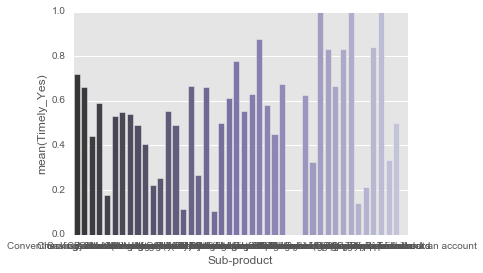

In [36]:
# plot sub-product vs. mean timeliness
sns.barplot(x="Sub-product", y="Timely_Yes", data=train_df, palette = 'Purples_d', ci = None);

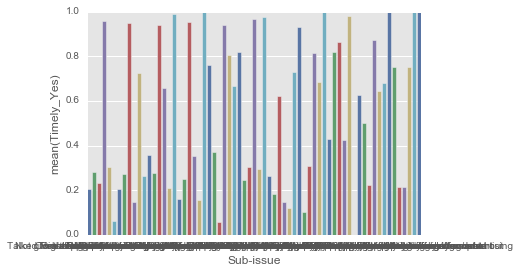

In [37]:
# plot sub-issue of complaint vs. mean timeliness
sns.barplot(x="Sub-issue", y="Timely_Yes", data=train_df, palette = 'deep', ci = None);

In [38]:
# Check response var index and datatype
train_df['Timely_Yes'].head()

265048    0.0
323794    1.0
512720    1.0
355725    1.0
169838    0.0
Name: Timely_Yes, dtype: float64

In [39]:
# Check feature set index and datatype
train_X.head()

NameError: name 'train_X' is not defined

In [41]:
# run initial logit regression with statsmodel
logit = sm.Logit(train_df['Timely_Yes'], train_X)
dispute_logit = logit.fit()

NameError: name 'train_X' is not defined

In [99]:
# print(dispute_logit.summary())

In [23]:
# Define Random Forest

In [24]:
# train_df.drop(['ZIP code', axis = 1, inplace = True)
train_df = train_df.drop(['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Company',
               'State', 'Tags', 'Submitted via', 'Company response to consumer'], axis = 1, inplace = True)   

In [25]:
train_df.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [75]:
# Define response variable
train_y = train_df['Timely_Yes']

In [ ]:
# Define feature set
train_X = train_df.drop(['Timely_Yes', 'Timely_No', 'Timely response?'], axis = 1, inplace = True)

In [ ]:
model = tree.DecisionTreeRegressor()

In [ ]:
model.fit(train_X, train_y)